In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import ta
import yfinance as yf

In [2]:
class StockPredictionAndAnomalyDetection:
    def __init__(self, time_steps=60, anomaly_model='IsolationForest'):
        self.time_steps = time_steps
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.lstm_model = None
        self.anomaly_model = anomaly_model
        self.anomaly_detector = None
        self.scaled_data = None

    def prepare_data(self, df):
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
        df['MACD'] = ta.trend.macd(df['Close'])
        df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'])
        df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'])
        df['ATR'] = ta.volatility.average_true_range(df['High'], df['Low'], df['Close'])
        df['Stochastic'] = ta.momentum.stoch(df['High'], df['Low'], df['Close'])
        df['OBV'] = ta.volume.on_balance_volume(df['Close'], df['Volume'])
        df['Volume_Change'] = df['Volume'].pct_change()
        df['Price_Change'] = df['Close'].pct_change()
        df.fillna(method='bfill', inplace=True)
        self.scaled_data = self.scaler.fit_transform(df[['Close', 'SMA_50', 'EMA_20', 'RSI', 'MACD', 'Bollinger_High', 'Bollinger_Low', 'ATR', 'Stochastic', 'OBV', 'Volume_Change', 'Price_Change']])
        return df

    def create_lstm_data(self):
        X, y = [], []
        for i in range(self.time_steps, len(self.scaled_data)):
            X.append(self.scaled_data[i-self.time_steps:i])
            y.append(self.scaled_data[i, 0])  # Close price as the target
        return np.array(X), np.array(y)

    def build_lstm_model(self):
        model = Sequential([
            LSTM(units=50, return_sequences=True, input_shape=(self.time_steps, self.scaled_data.shape[1])),
            Dropout(0.2),
            LSTM(units=50, return_sequences=False),
            Dropout(0.2),
            Dense(units=1)
        ])
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

    def train_lstm_model(self, X_train, y_train, X_val, y_val):
        lstm_checkpoint = ModelCheckpoint('combined_lstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')
        lstm_early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = self.lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[lstm_checkpoint, lstm_early_stop])
        self.lstm_model = load_model('combined_lstm_model.keras')
        return history

    def train_combined_model(self, df):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        X_train, X_val, y_train, y_val = X[:-200], X[-200:], y[:-200], y[-200:]
        self.lstm_model = self.build_lstm_model()
        self.train_lstm_model(X_train, y_train, X_val, y_val)
        predicted_prices = self.lstm_model.predict(X_val)
        predicted_prices = self.scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        actual_prices = self.scaler.inverse_transform(np.concatenate([y_val.reshape(-1, 1), np.zeros((y_val.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        residuals = actual_prices - predicted_prices
        
        if self.anomaly_model == 'IsolationForest':
            self.anomaly_detector = IsolationForest(contamination=0.05, random_state=42)
        elif self.anomaly_model == 'OneClassSVM':
            self.anomaly_detector = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
        elif self.anomaly_model == 'LocalOutlierFactor':
            self.anomaly_detector = LocalOutlierFactor(novelty=True, contamination=0.05)
        else:
            raise ValueError("Unsupported anomaly detection model.")
        
        self.anomaly_detector.fit(residuals.reshape(-1, 1))

    def detect_anomalies(self, df):
        df = self.prepare_data(df)
        X, y = self.create_lstm_data()
        predicted_prices = self.lstm_model.predict(X)
        predicted_prices = self.scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        actual_prices = self.scaler.inverse_transform(np.concatenate([y.reshape(-1, 1), np.zeros((y.shape[0], self.scaled_data.shape[1] - 1))], axis=1))[:, 0]
        residuals = actual_prices - predicted_prices
        anomalies = self.anomaly_detector.predict(residuals.reshape(-1, 1))
        return actual_prices, predicted_prices, anomalies

In [3]:
# Existing code for data fetching
ticker = 'GME'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-25')

[*********************100%%**********************]  1 of 1 completed


In [4]:
stockPrices.columns = stockPrices.columns.str.strip()

In [5]:
# Train and evaluate the combined model
model = StockPredictionAndAnomalyDetection(anomaly_model='IsolationForest')  # or 'OneClassSVM' or 'LocalOutlierFactor'
model.train_combined_model(stockPrices)

C:\Users\Loricson\AppData\Local\Temp\ipykernel_46480\1486765651.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
c:\Users\Loricson\anaconda3\envs\fyp-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 9.6613e-04 - val_loss: 0.0015
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - loss: 7.0603e-04 - val_loss: 0.0025
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - loss: 6.9720e-04 - val_loss: 0.0016
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 5.3541e-04 - val_loss: 0.0015
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 9.5248e-04 - val_loss: 0.0014
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 5.8600e-04 - val_loss: 0.0015
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 8.0127e-04 - val_loss: 0.0017
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0012 - val_loss: 0.0013
Epoch 12/50


In [6]:
# Detect anomalies on the validation set
actual_prices, predicted_prices, anomalies = model.detect_anomalies(stockPrices)

  7/175 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 

C:\Users\Loricson\AppData\Local\Temp\ipykernel_46480\1486765651.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


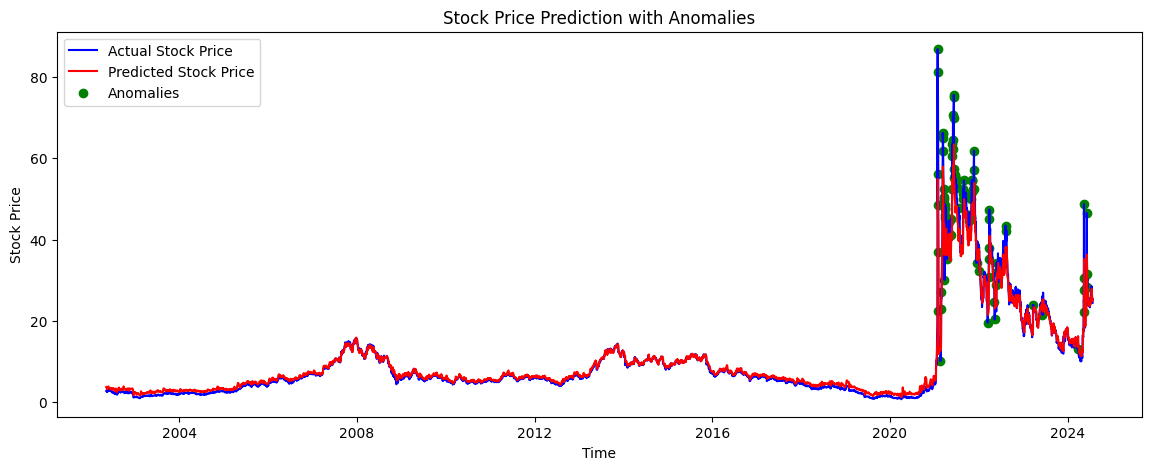

In [7]:
# Plot the results
plt.figure(figsize=(14, 5))
plt.plot(stockPrices.index[-len(predicted_prices):], actual_prices, color='blue', label='Actual Stock Price')
plt.plot(stockPrices.index[-len(predicted_prices):], predicted_prices, color='red', label='Predicted Stock Price')
plt.scatter(stockPrices.index[-len(predicted_prices):][anomalies == -1], actual_prices[anomalies == -1], color='green', label='Anomalies')
plt.title('Stock Price Prediction with Anomalies')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [8]:
# Print a summary of detected anomalies
print(f"Number of anomalies detected: {np.sum(anomalies == -1)}")
print(f"Percentage of data points marked as anomalies: {100 * np.mean(anomalies == -1):.2f}%")

Number of anomalies detected: 94
Percentage of data points marked as anomalies: 1.68%
